In [ ]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip

--2022-09-09 13:48:51--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.85.29
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.85.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘train-test-data.zip’

train-test-data.zip 100%[===================>] 322.93M  31.8MB/s    in 7.4s    

2022-09-09 13:48:59 (43.5 MB/s) - ‘train-test-data.zip’ saved [338613624/338613624]



In [ ]:
!unzip -n /content/train-test-data.zip -d /content/face_images/

Streaming output truncated to the last 5000 lines.
  inflating: /content/face_images/test/Elmar_Brok_21.jpg  
  inflating: /content/face_images/test/Elmar_Brok_30.jpg  
  inflating: /content/face_images/test/Elmar_Brok_31.jpg  
  inflating: /content/face_images/test/Elsa_Zylberstein_00.jpg  
  inflating: /content/face_images/test/Elsa_Zylberstein_01.jpg  
  inflating: /content/face_images/test/Elsa_Zylberstein_10.jpg  
  inflating: /content/face_images/test/Elsa_Zylberstein_11.jpg  
  inflating: /content/face_images/test/Elsa_Zylberstein_40.jpg  
  inflating: /content/face_images/test/Elsa_Zylberstein_41.jpg  
  inflating: /content/face_images/test/Elton_John_10.jpg  
  inflating: /content/face_images/test/Elton_John_11.jpg  
  inflating: /content/face_images/test/Elton_John_20.jpg  
  inflating: /content/face_images/test/Elton_John_21.jpg  
  inflating: /content/face_images/test/Elton_John_30.jpg  
  inflating: /content/face_images/test/Elton_John_31.jpg  
  inflating: /content/face_i

In [ ]:
import glob
import os
import pandas as pd
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as I
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [ ]:
#custom Dataset loading 
class FacialKeypointsDataset(Dataset):
  "Face Landmarks dataset"

  def __init__(self, csv_file, root_dir, transform=None):
    self.key_pts_frame = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
  
  def __len__(self):
    return len(self.key_pts_frame)
  
  def __getitem__(self,idx):
    image_name = os.path.join(self.root_dir, self.key_pts_frame.iloc[idx,0])
    image = mpimg.imread(image_name)

    if(image.shape[2] == 4):
      image = image[:,:,0:3]
    
    key_pts = self.key_pts_frame.iloc[idx,1:].to_numpy()
    key_pts = key_pts.astype('float').reshape(-1,2)
    sample = {'image':image, 'keypoints':key_pts}
    
    if self.transform:
      sample = self.transform(sample)
    
    return sample


In [ ]:
#Applying some transformations in our data

class Normalize(object):
  """Convert a colored image into grayscale image and convert color range in the range of [-1,1]"""

  def __call__(self, sample):
    image, key_pts = sample['image'], sample['keypoints']

    image_copy = np.copy(image)
    key_pts_copy = np.copy(key_pts)

    #converting images into grayscale
    image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

    #normalizing the images which is of 255px each
    image_copy = image_copy/255.0

    #key_pts_copy-mean/sqrt)
    key_pts_copy = (key_pts_copy-100)/50.0

    return {'image': image_copy, 'keypoints':key_pts_copy}

In [ ]:
#Rescaling
class Rescale(object):
  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    self.output_size = output_size
  
  def __call__(self, sample):
    image, key_pts = sample['image'], sample['keypoints']

    h,w = image.shape[:2]
    if isinstance(self.output_size, int):
      #calculating h/w as aspect ratio and then multiplying it by the requred output size
      #aspect ratio because the ratio of the height by width should be same.
      if h>w:
        new_h, new_w = self.output_size*h/w, self.output_size
      else:
        new_h, new_w = self.output_size, self.output_size*w/h
    else:
      new_h, new_w = self.output_size
    
    new_h, new_w = int(new_h), int(new_w)

    img = cv2.resize(image, (new_w, new_h))

    #scale the pts, too
    key_pts = key_pts* [new_w/w, new_h/h]
    return {'image': img, 'keypoints': key_pts}

In [ ]:
#Random Cropping
class RandomCrop(object):

  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    if isinstance(output_size, int):
      #if same size for height and width of the image
      self.output_size = (output_size, output_size)
    else:
      #if size for heigth and width is given in the tuple
      assert len(output_size) == 2
      self.output_size = output_size
  
  def __call__(self, sample):
    image, key_pts = sample['image'], sample['keypoints']

    h,w = image.shape[:2]
    new_h, new_w = self.output_size

    #subtracting the required height from the orginal height, then we get the remaining length.
    #From that we chose random integers and add that to the size of the height and widths that is required
    #which creates the random cropping of the image/ 
    top = np.random.randint(0, h-new_h)
    left = np.random.randint(0, w-new_w)

    image = image[top: top + new_h,
                  left: left + new_w]
    
    key_pts = key_pts - [left, top]

    return {'image':image, 'keypoints': key_pts}
  

In [ ]:
#ToTensor
class ToTensor(object):
  """Convert ndarrays in sample to tensors"""

  def __call__(self, sample):
    image, key_pts = sample['image'], sample['keypoints']

    #add one dimension for image which has no grayscale color channel
    if(len(image.shape)==2):
      #add third color dim
      image = image.reshape(image.shape[0], image.shape[1],1)
    
    #swapping color axis 
    #in numpy: H X W X C
    #in torch image: C X H X W

    image = image.transpose((2,0,1))

    return {'image': torch.from_numpy(image), 
            'keypoints': torch.from_numpy(key_pts)}



In [ ]:
#Defining the Network Architecture

In [ ]:
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

assert(data_transform is not None), ' Defining a Data Transform'

In [ ]:
#Creating the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/content/face_images/training_frames_keypoints.csv',
                                             root_dir='/content/face_images/training/',
                                             transform = data_transform
)
print('Number of Images: ', len(transformed_dataset))

for i in range(4):
  sample = transformed_dataset[i]
  print(i, sample['image'].size(), sample['keypoints'].size())

Number of Images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [ ]:
batch_size = 10
train_loader = DataLoader(transformed_dataset,
                          batch_size = batch_size,
                          shuffle = True,
                          num_workers = 4
                          )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
test_dataset = FacialKeypointsDataset(csv_file='/content/face_images/test_frames_keypoints.csv',
                                             root_dir='/content/face_images/test/',
                                             transform = data_transform
)

In [ ]:
batch_size = 10
test_loader = DataLoader(test_dataset,
                          batch_size = batch_size,
                          shuffle = True,
                          num_workers = 4
                          )

In [ ]:
# test the model on a batch of test images

def net_sample_output():
    net = Net()
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

In [ ]:
#Defining our CNN model

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    #conv2D(input_channels, output_channels, kernel_size, stride, padding, dilation)
    #input image is of 224*224 pixels
    #(n-f+1) x (n-f+1) ==> ((224-1)/1+5) = 220, using pool of 2 x 2 size, it converts to 110 size, convert it into 32 channels
    self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=5)
    self.pool1 = nn.MaxPool2d(2,2)
    self.fc_drop1 = nn.Dropout(p=0.2)

    #(110-5/1)+1=106
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=36, kernel_size=5)
    #converts 106 to 53
    self.pool2 = nn.MaxPool2d(2,2)
    self.fc_drop2 = nn.Dropout(p=0.2)

    #53-5+1=49
    self.conv3 = nn.Conv2d(in_channels=36, out_channels=48, kernel_size=5)
    #converts 49 to 24 ???????
    self.pool3 = nn.MaxPool2d(2,2)
    self.fc_drop3 = nn.Dropout(p=0.2)

    #24-3+1 = 22
    self.conv4 = nn.Conv2d(48, 64, 3)
    
    #22 --> 11
    self.pool4 = nn.MaxPool2d(2,2)
    self.fc_drop4 = nn.Dropout(p=0.2)

    #11-3+1 = 9
    self.conv5 = nn.Conv2d(64, 64, 3)
    #9 --> 4
    self.pool5 = nn.MaxPool2d(2,2)
    # self.fc_drop5 = nn.Dropout(p=0.2)
    
    self.fc6 = nn.Linear(64*4*4, 136)

  def forward(self, x):
    #building feedforward network

    x = self.pool1(F.relu(self.conv1(x)))
    x = self.fc_drop1(x)

    x = self.pool2(F.relu(self.conv2(x)))
    x = self.fc_drop2(x)

    x = self.pool3(F.relu(self.conv3(x)))
    x = self.fc_drop3(x)

    x = self.pool4(F.relu(self.conv4(x)))
    x = self.fc_drop4(x)

    x = self.pool5(F.relu(self.conv5(x)))
    
    #flatten
    x = x.view(x.size(0),-1)
    x = self.fc6(x)

    return x


In [ ]:
#visualizing the predicted keypoints
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

In [ ]:
# returns: test images, test predicted keypoints, test ground truth keypoints

test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


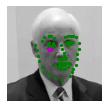

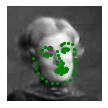

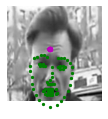

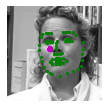

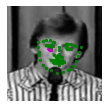

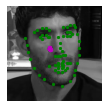

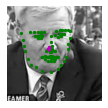

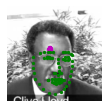

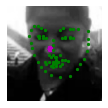

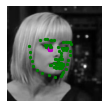

In [ ]:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

In [ ]:
#Training
import torch.optim as optim

net = Net()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)


In [ ]:
def train_net(n_epochs):
  loss_over_time = [] #tracking the loss as the network trains

  net.train()

  for epoch in range(n_epochs): #loop over the dataset

    running_loss = 0.0

    for batch_i, data in enumerate(train_loader):
      #get the input images and their corresponding keypoints
      image = data['image']
      key_pts = data['keypoints']
      
      #flattern the points
      key_pts = key_pts.view(key_pts.size(0),-1)

      #convert variables to floats
      key_pts = key_pts.type(torch.FloatTensor)
      images = image.type(torch.FloatTensor)

      #forward pass to get outputs
      output_pts = net(images)

      # calculate the loss between predicted and target keypoints
      loss = criterion(output_pts, key_pts)

      optimizer.zero_grad()
      loss.backward()

      # update the weights
      optimizer.step()

      # print loss statistics
      running_loss += loss.item()
      if batch_i % 10 == 9:    # print every 10 batches
          print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
          running_loss = 0.0

  print('Finished Training')
  return loss_over_time

In [ ]:
n_epochs = 30
train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.5926312178373336
Epoch: 1, Batch: 20, Avg. Loss: 0.5216858297586441
Epoch: 1, Batch: 30, Avg. Loss: 0.24801097363233565
Epoch: 1, Batch: 40, Avg. Loss: 0.20923210680484772
Epoch: 1, Batch: 50, Avg. Loss: 0.34687268882989886
Epoch: 1, Batch: 60, Avg. Loss: 0.15485127940773963
Epoch: 1, Batch: 70, Avg. Loss: 0.16892093569040298
Epoch: 1, Batch: 80, Avg. Loss: 0.17646406963467598
Epoch: 1, Batch: 90, Avg. Loss: 0.21286494433879852
Epoch: 1, Batch: 100, Avg. Loss: 0.17746009081602096
Epoch: 1, Batch: 110, Avg. Loss: 0.2824996471405029
Epoch: 1, Batch: 120, Avg. Loss: 0.20207321047782897
Epoch: 1, Batch: 130, Avg. Loss: 0.21908794865012168
Epoch: 1, Batch: 140, Avg. Loss: 0.3407139502465725
Epoch: 1, Batch: 150, Avg. Loss: 0.21319533735513688
Epoch: 1, Batch: 160, Avg. Loss: 0.1774703659117222
Epoch: 1, Batch: 170, Avg. Loss: 0.1728912115097046
Epoch: 1, Batch: 180, Avg. Loss: 0.18177309930324553
Epoch: 1, Batch: 190, Avg. Loss: 0.21887995302677155
Epoch: 1

[]

In [ ]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


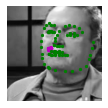

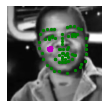

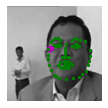

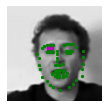

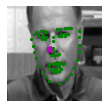

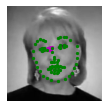

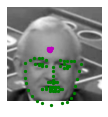

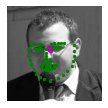

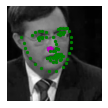

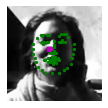

In [ ]:
visualize_output(test_images, test_outputs, gt_pts)

In [ ]:
model_dir = '/content/saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)